In [41]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [42]:
%load_ext autoreload
%autoreload 2

import os
import datetime
from collections import defaultdict

import numpy as np
import scipy

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, PolytopeFeasibility
from methods import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def train_loop(p: int, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    n = 200
    d = 100
    
    # dataset
    data = np.random.rand(n, d) * 2 - 1
    w_star =  np.random.rand(d) * 2 - 1
    target = data @ w_star
    
    # parameters
    w = np.zeros(d)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = PolytopeFeasibility(data, target, p)
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)

        optim.step(oracle=loss_function)

        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )}")
        history["loss"].append(loss)
        history["grad_norm_sq"].append(np.linalg.norm(grad) ** 2)
        history["time"].append(time)
    
    return history

In [ ]:
hyperparams = {
    "DampedNewton": {"lr": -1.0},
    "AICN": {"L_est": 1.0},
    "RootNewton": {"q": 2.0, "L_est": 0.5},
    "SimpliReg": {"beta": 0.001, "sigma": 1.0},
    "GradientMethod": {"L_est": 1.0}, 
    "UniversalNewton": {"sigma_0": 1.0, "c": 3.5},
}

In [45]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markersizes=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, ylims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if f_star is None:
        f_star = np.min([x["loss"] for x in histories])
    else:
        f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m, ms in zip(histories, labels, colors, linestyles, linewidths, markers, markersizes):
        f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
    
        markevery = [0, ] + [x + np.random.randint(0, 2) for x in range(0, len(history["loss"]) - 2, len(history["loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markersize=ms)
        ax[1].semilogy(history["time"], f_suboptim, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markersize=ms)


    if f_star.sum() == 0.0:
        ax[0].set_ylabel(r"$f(x_k)/f(x_0)$")
        ax[1].set_ylabel(r"$f(x_k)/f(x_0)$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")
        ax[1].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")

    ax[0].set_xlabel("Steps")
    ax[1].set_xlabel("Time, sec")
    
    if xlims is not None:
        ax[0].set_xlim(left=xlims[0][0], right=xlims[0][1])
        ax[1].set_xlim(left=xlims[1][0], right=xlims[1][1])

    if ylims is not None:
        ax[0].set_ylim(bottom=ylims[0][0], top=ylims[0][1])
        ax[1].set_ylim(bottom=ylims[1][0], top=ylims[1][1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show() 

In [46]:
np.random.seed(0)

n_steps = 100
p = 2

histories = []
labels = []

# Root Newton
q = 2.0
L_est = 0.0001
hist = train_loop(p=p, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = 0.01
hist = train_loop(p=p, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(p=p, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = 2.0
L_est = 0.0001
hist = train_loop(p=p, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

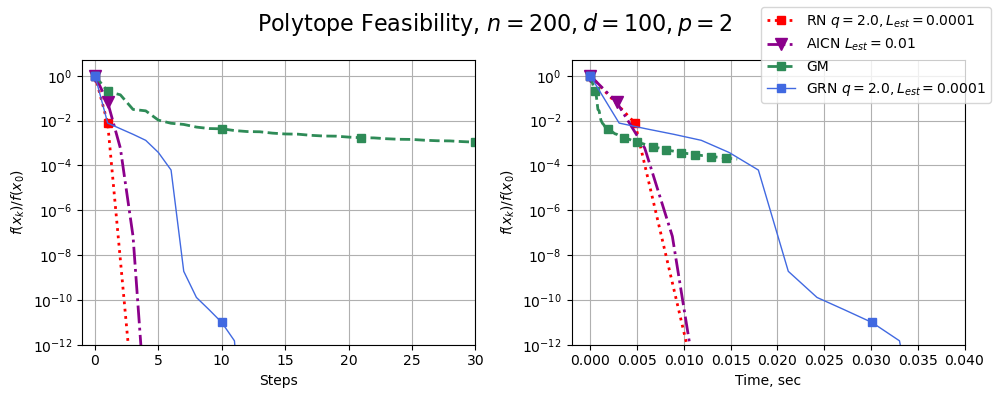

In [195]:
plotter(histories=histories, 
        labels=labels,
        colors=["red", "darkmagenta", "seagreen", "royalblue"],
        linestyles=[":", "-.", "--", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.0],
        markers=["s", "v", "s", "s"],
        markersizes=[6, 8, 6, 6],
        suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$".format(200, 100, p),
        threshold=1e-12,
        f_star=0.0,
        ylims=[(1e-12, 5.0), (1e-12, 5.0)],
        xlims=[(-1.0, 30), (-0.002, 0.04)],
        filename=f"polytope_rn_p_{p}.pdf")

In [47]:
damped_newton_lrs = {
    2: 0.95,
    3: 1.95,
    4: 2.95,
    5: 3.95,
}

In [88]:
np.random.seed(0)


n_steps = 200
p = 5

histories = []
labels = []

# Damped Newton
for lr in [3.8, 3.99, 4.0, 4.1]:
    hist = train_loop(p=p, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
    histories.append(hist)
    labels.append(f"Newton, lr={lr}")

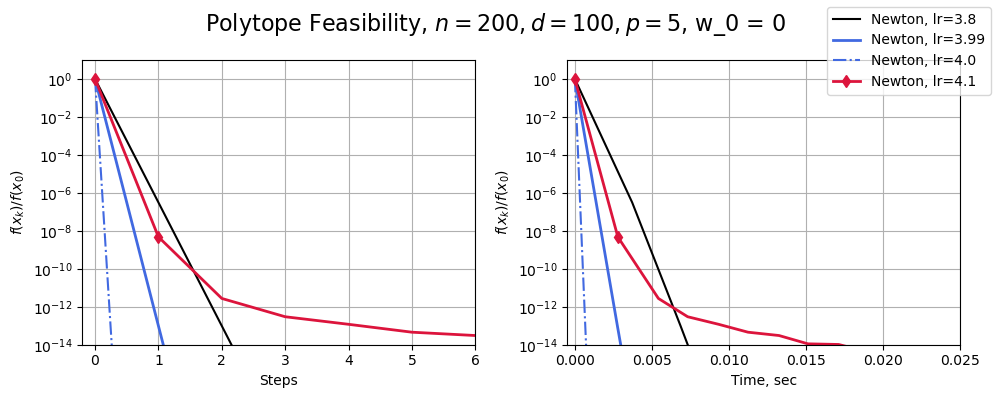

In [92]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-."],
        linewidths=[1.5, 2.0, 1.5, 2.0, 1.5],
        markers=[" ", " ", " ", "d", "d"],
        markersizes=[8, 6, 6, 6, 6],
        suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$, w_0 = 0".format(200, 100, p),
        threshold=1e-16,
        f_star=0.0,
        ylims=[(1e-14, 10.0), (1e-14, 10.0)],
        xlims=[(-0.2, 6), (-0.0005, 0.025)])


In [23]:
np.random.seed(0)


n_steps = 200
p = 5

histories = []
labels = []

# Damped Newton
hist = train_loop(p=p, n_steps=n_steps, optimizer=DampedNewton, lr=damped_newton_lrs[p])
histories.append(hist)
labels.append(f"Newton, lr={damped_newton_lrs[p]}")

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):
    hist = train_loop(p=p, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, {0}".format(l))

# Universal Newton
sigma_0 = hyperparams["UniversalNewton"]["sigma_0"]
c = hyperparams["UniversalNewton"]["c"]
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(p=p, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, {0}".format(l))

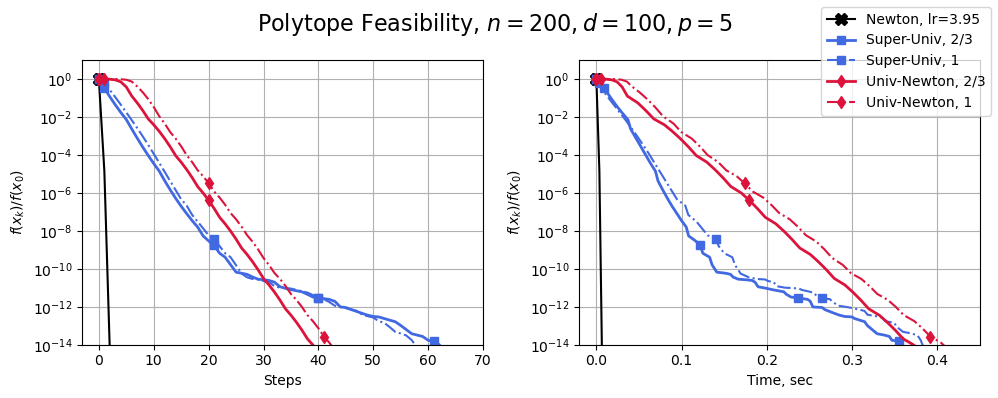

In [24]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-."],
        linewidths=[1.5, 2.0, 1.5, 2.0, 1.5],
        markers=["X", "s", "s", "d", "d"],
        markersizes=[8, 6, 6, 6, 6],
        suptitle=r"Polytope Feasibility, $n={0}, d={1}, p={2}$".format(200, 100, p),
        threshold=1e-16,
        f_star=0.0,
        ylims=[(1e-14, 10.0), (1e-14, 10.0)],
        xlims=[(-3.0, 70), (-0.02, 0.45)],
        filename=f"polytope_univ_p_{p}.pdf")
